In [8]:
from tensorflow.keras.models import load_model
model = load_model(r'D:\B__WorkSpace\AI\jupyter notebook for deep learninig\cats_and_dogs_small_1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Preprocessing a single image

In [10]:
img_path = r'D:\B__WorkSpace\AI\dl_project_cnn\kagglecatsanddogs_small\test\cats\cat.1700.jpg'

# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.
# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Displaying the test picture

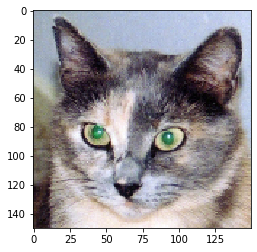

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])

Instantiating a Model from an input tensor and a list of output tensors

In [13]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Running our model in predict mode

In [14]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

First entry in the outputs: the output of the first layer of the original model

In [15]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Plotting the 4th channel of the activation of the first layer of the
original model

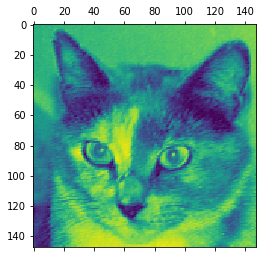

In [16]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

4th channel of the activation of the first layer on our test cat picture,
This channel appears to encode a diagonal edge detector

Plotting the 7th channel of the activation of the first layer of the original model

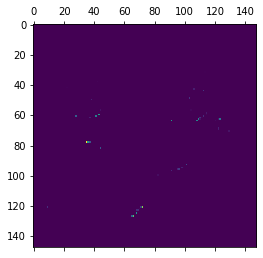

In [17]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

7th of the activation of the first layer on our test cat picture,
This one looks like a "bright green dot" detector, useful to encode cat eyes.


Visualizing every channel in every intermediate activation

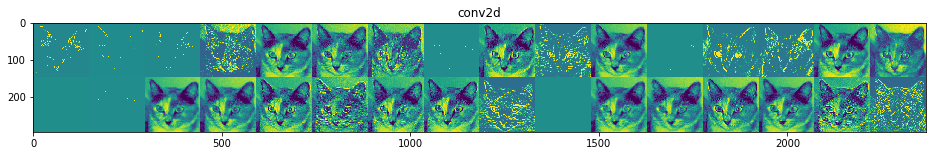

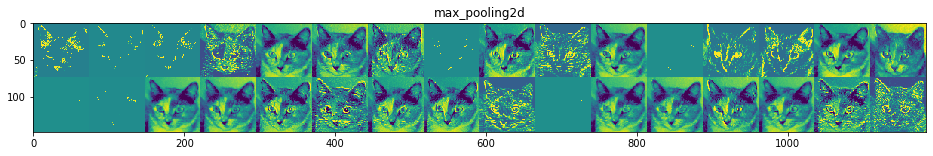

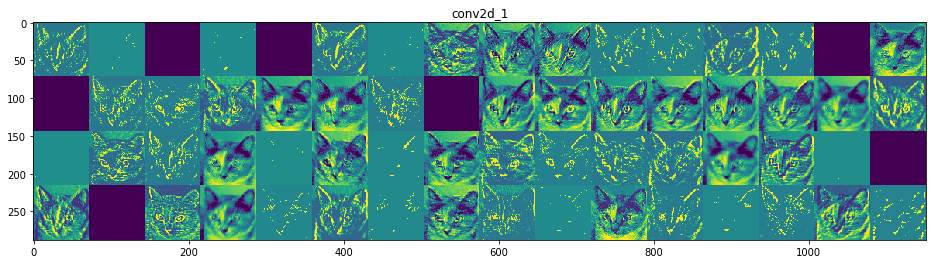

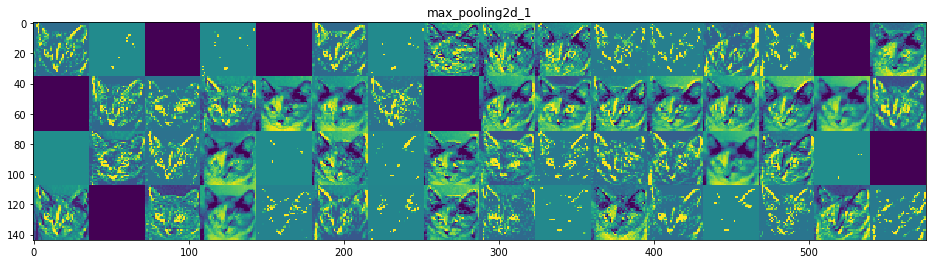

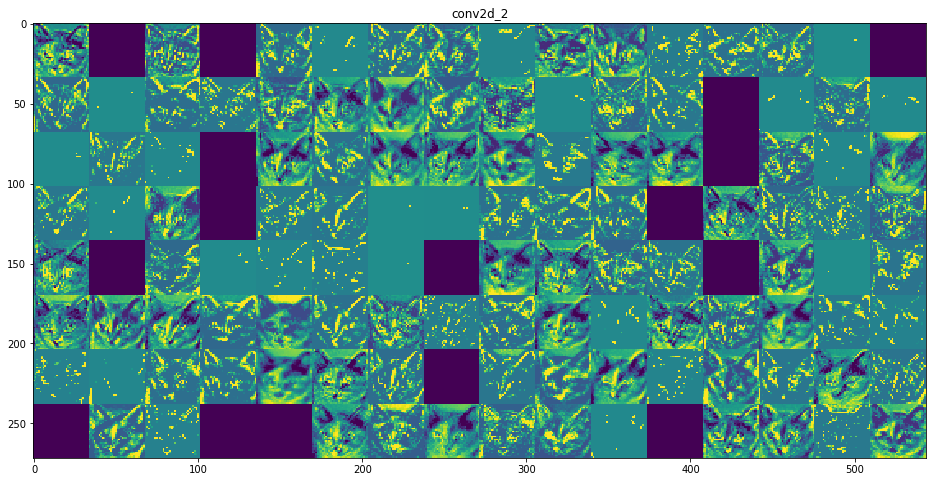

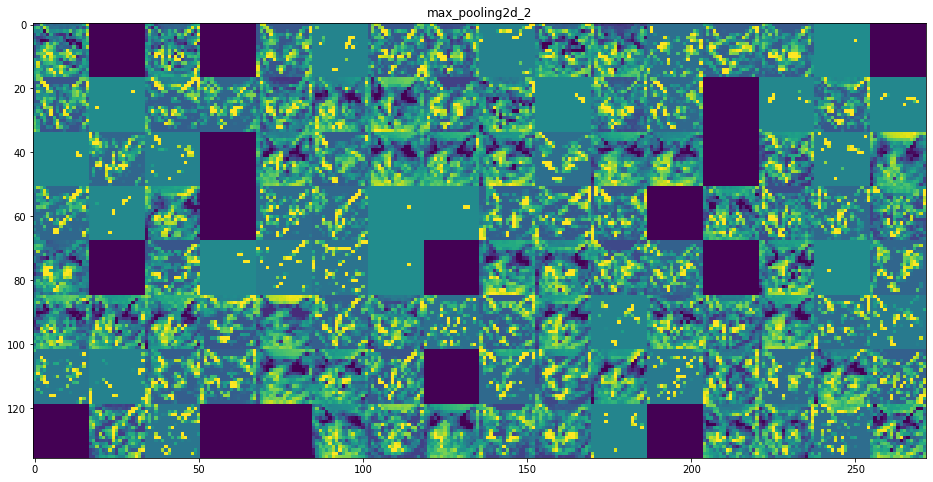

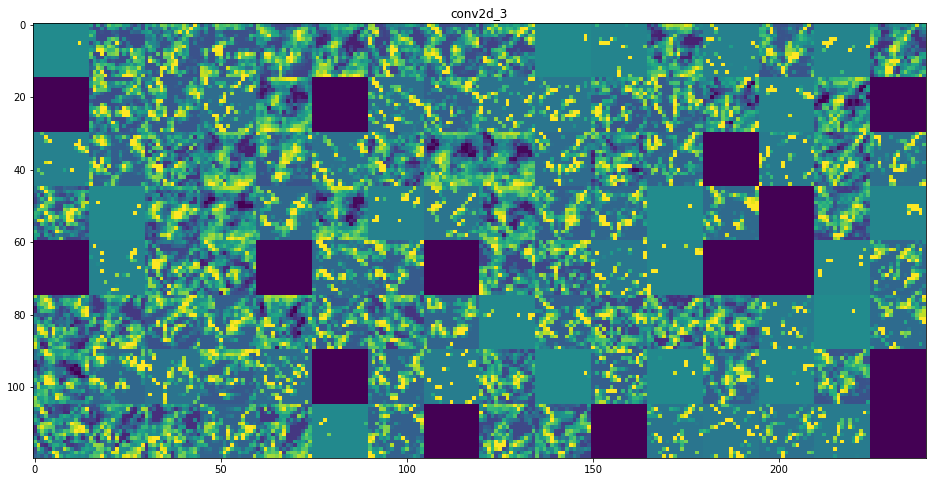

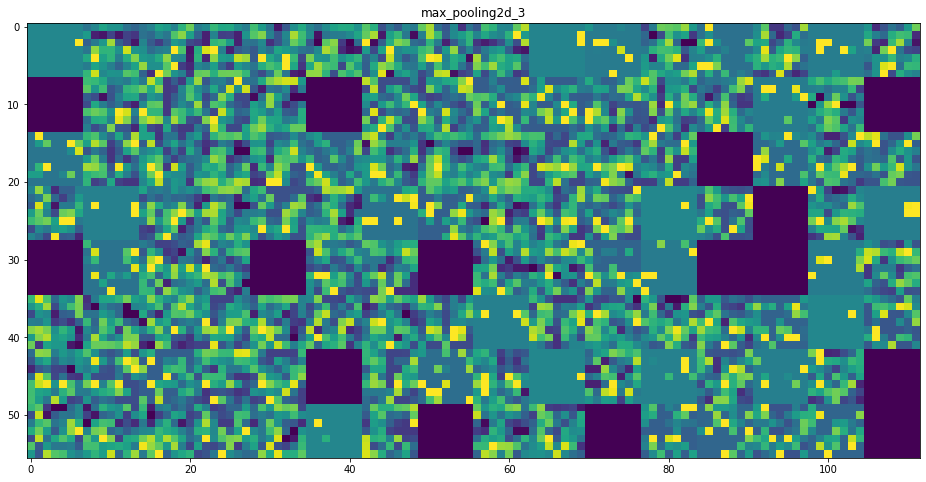

In [19]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Every channel of every layer activation on test cat picture




Visualizing convnet filters

Defining the loss tensor for filter visualization

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
                include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Obtaining the gradient of the loss with regard to the input

In [30]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
# grads = K.gradients(loss, model.input)[0]
import tensorflow as tf
with tf.GradientTape() as gtape:
    grads = gtape.gradient(loss, model.input)

The gradient normalization trick

Defining a Keras function for fetching Numpy output values given
Numpy input values

Loss maximization via stochastic gradient descent over the input parameters

Utility function to convert a tensor into a valid image

In [37]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Putting it all together: a function to generate filter visualizations

In [39]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])

    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

Visualising the response patterns of filter 0 of block3_conv1

Generating of grid of all filter response patterns in a layer